In [ ]:
!pip install sentence_transformers funcy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 2.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [ ]:
from sentence_transformers import SentenceTransformer
from funcy import print_durations

encoder_model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

@print_durations
def get_embeddings(labels, sent_tran_model):
    embeddings = sent_tran_model.encode(labels, show_progress_bar=False)
    return embeddings

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.73k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
words = ["larger than", "more fat", "is very wide", "is going to vote for", "supports", "very big", "endorses", "is very likely going to support"]
# words = ["fish out", "take out", "bring out", "pull out", "remove", "withdraw", "extract", "draw out", "large", "fat", "wide", "big"]

In [ ]:
embeddings = get_embeddings(words, encoder_model)

  335.97 ms in get_embeddings(['larger than', 'more ..., SentenceTransformer( (...)


In [ ]:
from sklearn.cluster import KMeans


def cluster_embeddings(embeddings, n_clusters=2):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    kmeans.fit(embeddings)
    return kmeans.cluster_centers_, kmeans.labels_

In [ ]:
cluster_centers, cluster_labels = cluster_embeddings(embeddings)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
print(cluster_labels)

[1 1 1 0 0 1 0 0]


In [ ]:
from transformers import DebertaV2TokenizerFast, DebertaV2ForSequenceClassification
import torch
from tqdm import trange
from math import ceil, exp


class EntailmentModel:

    def __init__(self):
        self.tokenizer = DebertaV2TokenizerFast.from_pretrained("microsoft/deberta-v2-xxlarge-mnli")
        self.model = DebertaV2ForSequenceClassification.from_pretrained(
            "microsoft/deberta-v2-xxlarge-mnli", torch_dtype=torch.float16
        ).to('cuda', dtype=torch.float16)

    def inference(self, sents, batch_size=1, silent=False):
        scores = []
        for i in trange(ceil(len(sents) / batch_size), desc='Entailment scoring...', ncols=100,
                       disable=silent):
            inputs = self.tokenizer(
                sents[batch_size*i : batch_size*(i+1)],
                padding=True, return_tensors="pt"
            ).to('cuda')
            results = self.model(**inputs)
            results.logits = results.logits.to('cpu')
            scores.extend([
                float(exp(r[2]) - exp(r[0]))
                for r in results.logits
            ])
            inputs = inputs.to('cpu')
        return scores

    def entailment_score(self, pairs, silent=False, batch_size=1):
        inputs = [f"[CLS] {antecedent} [SEP] {consequent} [SEP]"
                  for antecedent, consequent in pairs]
        return self.inference(inputs, silent=silent, batch_size=batch_size)


In [ ]:
model = EntailmentModel()

In [ ]:
import networkx as nx

def get_cluster_representatives(cluster_words, entailment_model, threshold=5.0):
    pairs = [(f"X {word1} Y", f"X {word2} Y") for word1 in cluster_words for word2 in cluster_words if word1 != word2]
    scores = entailment_model.entailment_score(pairs, silent=True, batch_size=4)

    G = nx.DiGraph()
    for (word1, word2), score in zip(pairs, scores):
        if score >= threshold:
            G.add_edge(word1, word2, weight=score)

    G_transitive = nx.transitive_closure(G)

    centrality = nx.in_degree_centrality(G_transitive)

    sorted_words = sorted(centrality, key=centrality.get, reverse=True)

    best_words = [word[2:-2] for word in sorted_words[:2]]

    return best_words, G, G_transitive

In [ ]:
from collections import defaultdict, Counter


cluster_to_words = defaultdict(list)
for word, label in zip(words, cluster_labels):
    cluster_to_words[label].append(word)

best_predicate = {}
graphs = {}
for label, cluster_words in cluster_to_words.items():

    best_words, G, G_transitive = get_cluster_representatives(cluster_words, model)
    best_predicate[label] = best_words
    graphs[label] = (G, G_transitive)

In [ ]:
print("Top two representatives for each cluster:", best_predicate)

Top two representatives for each cluster: {1: ['larger than', 'is very wide'], 0: ['supports', 'endorses']}


In [ ]:
from matplotlib import pyplot as plt

def visualize_graph(G, title):
    generic = Counter()

    for a, b in G.edges:
        if a != b:
            generic[b] += 1

    fig, ax = plt.subplots()

    nx.draw_circular(G, ax=ax, with_labels=True, labels={n: n[2:-2] for n in G.nodes()},
        node_color='#addfff', edge_color='gray', node_size=2000, arrowsize=20)

    ax.set_xlim(-2.0, 2.0)
    ax.set_ylim(-2.0, 2.0)

    plt.title(title)
    plt.show()

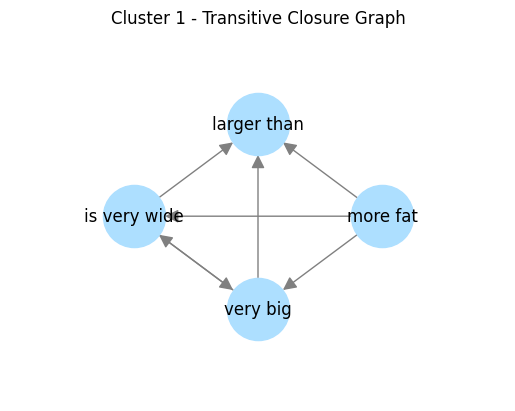

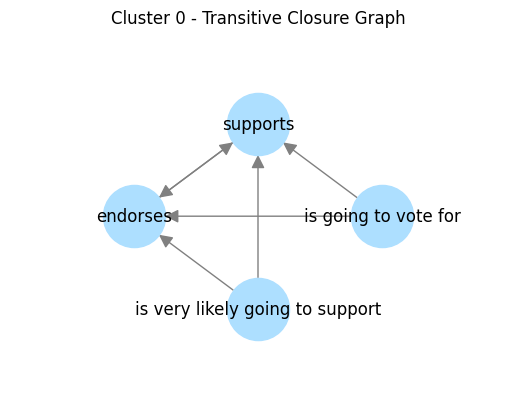

In [ ]:
for label, (G, G_transitive) in graphs.items():

    # print(f"Original Graph: {G.edges(data=True)}")
    # visualize_graph(G, f"Cluster {label} - Original Graph")
    # print(f"Transitive Closure Graph: {G_transitive.edges(data=True)}")
    visualize_graph(G_transitive, f"Cluster {label} - Transitive Closure Graph")